In [88]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
import os

import numpy as np
import pytorch_dataset
import pytorch_datamodule

import matplotlib.pyplot as plt
import pandas as pd

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [90]:
df = pd.read_parquet('/Users/user/repos/zoobot-3d/data/gz3d_and_desi_master_catalog.parquet')
df = df[df['smooth-or-featured_featured-or-disk_fraction'] > 0.5]
df = df[df['disk-edge-on_yes_fraction'] < 0.5]
df = df[df['has-spiral-arms_yes_fraction'] > 0.5]
len(df)

80286

In [91]:
df.columns.values

array(['ra_manga', 'dec_manga', 'mangaid', 'iauname', 'ifudesignsize',
       'manga_tileid', 'nsa_id', 'explorer_link',
       'gz_total_classifications', 'gz_bar_votes', 'gz_spiral_votes',
       'sample', 'relative_gz3d_fits_loc', 'best_match', 'sky_separation',
       'ra_desi', 'dec_desi', 'dr8_id', 'mag_r', 'mag_g', 'mag_z',
       'est_dr5_pixscale', 'galahad_fits_loc', 'galahad_jpg_loc',
       'relative_desi_fits_loc', 'relative_desi_jpg_loc',
       'relative_segmap_json_loc', 'relative_spiral_mask_loc',
       'relative_bar_mask_loc', 'smooth-or-featured-dr12_smooth',
       'smooth-or-featured-dr12_featured-or-disk',
       'smooth-or-featured-dr12_artifact', 'disk-edge-on-dr12_yes',
       'disk-edge-on-dr12_no', 'has-spiral-arms-dr12_yes',
       'has-spiral-arms-dr12_no', 'bar-dr12_yes', 'bar-dr12_no',
       'bulge-size-dr12_dominant', 'bulge-size-dr12_obvious',
       'bulge-size-dr12_none', 'how-rounded-dr12_completely',
       'how-rounded-dr12_in-between', 'how-roun

In [92]:
df['spiral_mask_loc'] = df['relative_spiral_mask_loc']
df['bar_mask_loc'] = df['relative_bar_mask_loc']
df['desi_jpg_loc'] = df['relative_desi_jpg_loc']

In [93]:
df['spiral_mask_exists'] = df['spiral_mask_loc'].apply(os.path.isfile)
df = df.query('spiral_mask_exists')
len(df)

6382

In [94]:
# transform = A.Compose(
#     [
#         A.CenterCrop(250, 250)
#     ],
#     additional_targets={'spiral_mask': 'image', 'bar_mask': 'image'}
# )

# transform = None

from train import default_segmentation_transforms

transform = default_segmentation_transforms()

In [95]:
from zoobot.shared.schemas import decals_all_campaigns_ortho_schema

label_cols = decals_all_campaigns_ortho_schema.label_cols

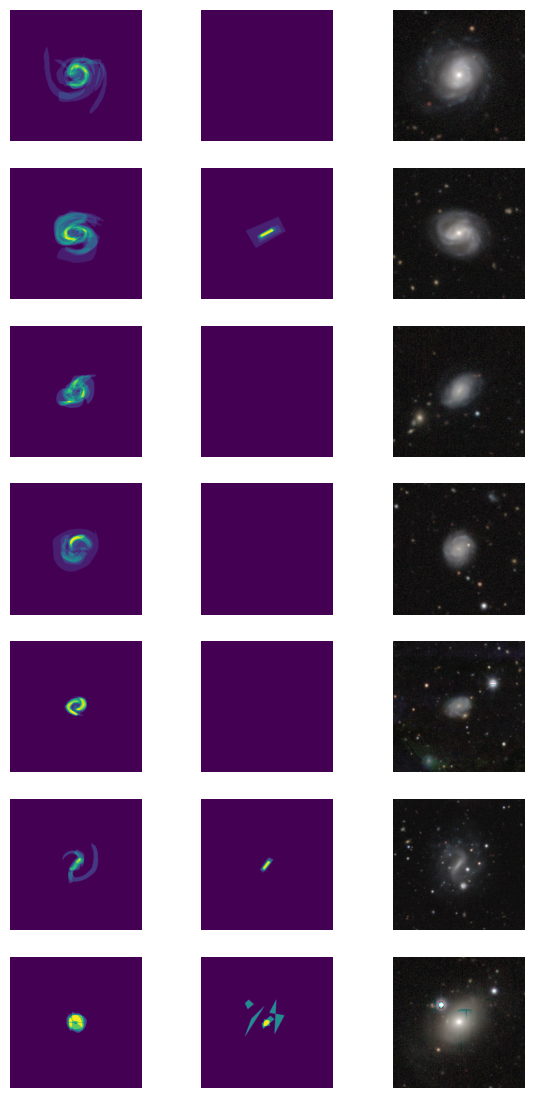

In [96]:
n_examples = 7

dataset = pytorch_dataset.SegmentationGalaxyDataset(
    df.sample(n_examples), transform=None, label_cols=label_cols)

fig, rows = plt.subplots(ncols=3, nrows=n_examples, figsize=(7, 2*n_examples))


for galaxy_n in range(n_examples):

    (ax0, ax1, ax2) = rows[galaxy_n]

    outputs = dataset[galaxy_n]
   
    ax0.imshow(outputs['spiral_mask'].squeeze())
    ax1.imshow(outputs['bar_mask'].squeeze())
    ax2.imshow(outputs['image'].squeeze())  # default target keyed as image
    ax0.axis('off')
    ax1.axis('off')
    ax2.axis('off')

plt.show()

In [97]:
print(outputs['spiral_mask'].max())

255


In [98]:
print(outputs['label_cols'])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


## Check DataModule 

In [99]:
transform = A.Compose(
    [
        A.CenterCrop(250, 250),
        ToTensorV2()
    ],
    additional_targets={'spiral_mask': 'image', 'bar_mask': 'image'}
)

In [108]:
datamodule = pytorch_datamodule.SegmentationDataModule(
    train_catalog=df[:100],
    val_catalog=df[200:300],
    test_catalog=df[300:400],
    batch_size=50,
    num_workers=1,
    label_cols=label_cols,
    transform=transform
)
datamodule.setup('fit')

In [109]:
for batch in datamodule.train_dataloader():
    # print(len(batch))
    print(batch.keys())
    break

GZDESI/GZRings/GZCD not available from galaxy_datasets.pytorch.datasets - skipping
dict_keys(['image', 'spiral_mask', 'bar_mask', 'label_cols'])


In [110]:
batch['label_cols']

tensor([[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [ 1., 26.,  2.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]])

In [111]:
batch['image'].shape

torch.Size([50, 3, 250, 250])

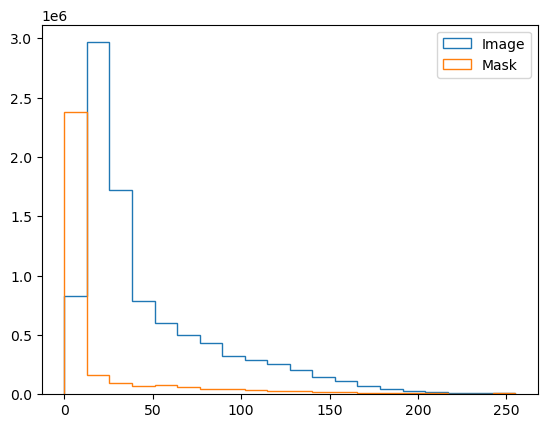

In [112]:
_ = plt.hist(batch['image'].flatten(), bins=20, histtype='step', label='Image')
_ = plt.hist(batch['spiral_mask'].flatten(), bins=20, histtype='step', label='Mask')
plt.legend()

In [113]:
batch['image'].shape

torch.Size([50, 3, 250, 250])

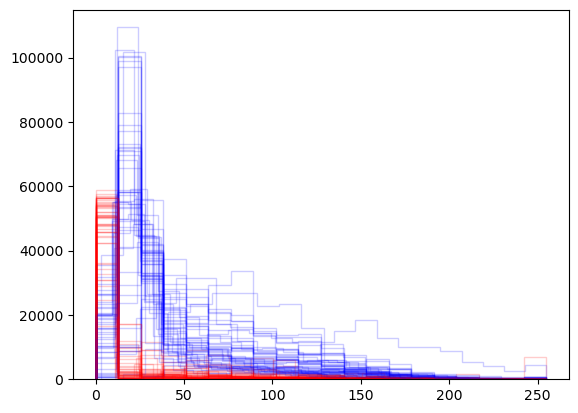

In [117]:
_, bins = np.histogram(np.linspace(0., 255.))
fig, ax = plt.subplots()
for im_index in range(len(batch['image'])):
    _ = ax.hist(batch['image'][im_index].flatten(), bins=20, histtype='step', color='b', alpha=.2)
    _ = ax.hist(batch['spiral_mask'][im_index].flatten(), bins=20, histtype='step', color='r', alpha=.2)
# plt.legend()

(-0.5, 249.5, 249.5, -0.5)

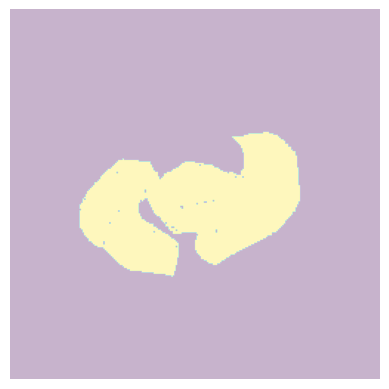

In [115]:
im = batch['image'][0].squeeze().transpose(0, 2)
mask = batch['spiral_mask'][0].squeeze()

# plt.imshow(im)
# plt.imshow((im < 5).numpy().astype(float), alpha=.3)
# plt.imshow((im < 50).numpy().astype(float), alpha=.3)

# plt.imshow(mask)
# plt.imshow((mask < 30).numpy().astype(float), alpha=.3)
# plt.imshow(((mask > 30) & (mask < 70)).numpy().astype(float), alpha=.3)
plt.imshow((mask > 70).numpy().astype(float), alpha=.3)

plt.axis('off')